## Log
computed VQE values in noisy simulation for ibmq_rome and executed those on it in fair share queue on cluster over night  
no major improvements  
will also try the full VQE optimization but it takes too long for dedicated mode, will have to try if we can get something in reasonable time in the fair share queue.

In [1]:
import sys
sys.path.insert(1, '..') # sets the path to the parent folder, where the notebook was originally executed


import time
import datetime
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit import *
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
from qiskit.opflow import CircuitSampler


from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

In [2]:
anti = -1
L = 5
num_trash = 2

name = "ibmq_antiferro-1D-load_bogota-optimize" # remove test at the end when running on a real device
filename = "data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20" #"data/noisy_VQE_maxiter-100_Ising_L5_anti_-1_20_recycle"
print("filename: ", filename, "notebook name: ", name)

# where to get the simulated thetas values from? needs to contain a thetas_mitigated array
filename_simulated_thetas = 'data/ibmq_antiferro-1D-load_simu_thetas-loss-cost_run2.npz' 

filename:  data/noisy_VQE_maxiter-500_Ising_L5_anti_-1_20 notebook name:  ibmq_antiferro-1D-load_bogota-optimize


In [3]:
load = False
recompute = True # whether or not to recompute Magnetization, makes sense on device

In [4]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

In [5]:
device = provider.backend.ibmq_rome
print(device)

ibmq_rome


In [6]:
backend = device
#backend = qiskit.providers.aer.AerSimulator.from_backend(device)

In [7]:
coupling_map = device.configuration().coupling_map
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [8]:
#aqua_globals.random_seed = seed
qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                         coupling_map=coupling_map, #, noise_model=noise_model,
                         measurement_error_mitigation_cls= CompleteMeasFitter, 
                         cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                 )

In [9]:
# Very important, at the moment poorly coded so it needs to come back to this instance all the time
ansatz = qiskit.circuit.library.TwoLocal(L,rotation_blocks="ry", entanglement_blocks='cz', entanglement="sca", reps=1)
#ansatz.draw("mpl")


In [10]:
ansatz = qiskit.transpile(ansatz, backend)
#ansatz.draw("mpl")

## VQE

## Magnetization

In [11]:
L = 5
num_trash = 2
anti = -1

VQE_params = np.load(filename + ".npz", allow_pickle=True)
pick = np.arange(0,len(VQE_params['gx_list']),3)
gx_list = VQE_params['gx_list'][pick]
gz_list = VQE_params['gz_list'][pick]
opt_params = VQE_params['opt_params'][pick]
Qmags = VQE_params["Qmag"][pick]
Qen = VQE_params["Qen"][pick]
Sen = VQE_params["Sen"][pick]
Smags = VQE_params["Smag"][pick]

gx_vals = np.unique(gx_list)
gz_vals = np.unique(gz_list)

In [12]:
if load:
    temp = np.load("data/" + name + "executed_mags-Es.npz",allow_pickle=True)
    Qmags = temp["Qmags"]
    Qen = temp["Qen"]
    Sen = temp["Sen"]
    Smags = temp["Smags"]

In [14]:
verbose=1
if recompute:
    mag = QMag(L,anti) #magnetization operator (Qiskit)
    Smag = Mag(L,anti) #magnetization operator (numpy)

    Qen_executed=np.zeros(len(opt_params), dtype="complex")
    Qmags_executed=np.zeros(len(opt_params), dtype="complex")
    for j in range(len(opt_params)):
        t0 = datetime.datetime.now()
        gx = gx_list[j]
        gz = gz_list[j]
        H = QHIsing(L, anti, np.float32(gx), np.float32(gz)) # build Hamiltonian Op
        state = ansatz.assign_parameters(opt_params[j])
        meas_outcome = ~StateFn(mag) @ StateFn(state)

        Qmags_executed[j] = CircuitSampler(qi).convert(meas_outcome).eval() #https://quantumcomputing.stackexchange.com/questions/12080/evaluating-expectation-values-of-operators-in-qiskit
        #e_outcome = ~StateFn(H) @ StateFn(state)
        #Qen_executed[j] = CircuitSampler(qi).convert(e_outcome).eval()
        
        
        init_state, E, ham = ising_groundstate(L, anti, np.float64(gx), np.float64(gz))
        Sen[j] = E
        Smags[j] = init_state.T.conj()@Smag@init_state #Magnetization with Numpy results
        print(f"{j+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {(datetime.datetime.now() - t0)}")
    np.savez("data/" + name + "executed_mags-Es.npz",Qmags=Qmags_executed, Qen=Qen_executed, Sen=Sen, Smags=Smags) # for large parameter space takes quite a while because of the exact diagonalization

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:382: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, **backend_options, **noise_config)


1 / 7, gx = 0.01, gz = 0.00, time : 0:11:33.858661
2 / 7, gx = 0.04, gz = 0.00, time : 0:12:45.922142
3 / 7, gx = 0.18, gz = 0.00, time : 0:25:00.566525
4 / 7, gx = 0.78, gz = 0.00, time : 0:00:48.637380
5 / 7, gx = 3.36, gz = 0.00, time : 0:01:08.997483
6 / 7, gx = 14.38, gz = 0.00, time : 0:01:21.406575
7 / 7, gx = 61.58, gz = 0.00, time : 0:01:14.933926


In [16]:
temp = np.load("data/ibmq_antiferro-1D-load_bogota-optimize-20pointsexecuted_mags-Es.npz",allow_pickle=True)
Qmags_executed_bogota = temp["Qmags"]

/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


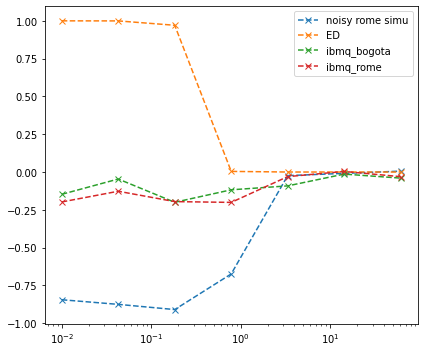

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(6,5))
ax.plot(gx_list, Qmags,"x--", label="noisy rome simu")
ax.plot(gx_list, Smags,"x--", label="ED")
ax.plot(gx_list, Qmags_executed_bogota[::3],"x--", label="ibmq_bogota")

if recompute:
    ax.plot(gx_list, Qmags_executed,"x--", label="ibmq_rome")
ax.legend()
ax.set_xscale("log")
plt.tight_layout()
plt.savefig("plots/temp_compare-bogota-rome_vqe-vals-from-noisy-rome-simulation.png")

In [33]:
##############################################################################
### II - Training  ###########################################################
##############################################################################

In [34]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1, nums_trash=[1,2]):
    result = []

    nums_compressed = list(range(L))
    for trashqubit in nums_trash:
        nums_compressed.remove(trashqubit)
    if nums_trash == None: #old way  
        nums_compressed = list(range(L))[:L-num_trash]
        nums_trash = list(range(L))[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

def QAE_Ansatz(thetas, L, num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz", nums_trash = [1,2]):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    if nums_trash == None:
        nums_trash = list(range(L))[-num_trash:]
    circ = qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                           skip_final_rotation_layer=True
                                          ).assign_parameters(thetas[:-num_trash])
    if insert_barriers: circ.barrier()

    for i in nums_trash:
        circ.ry(thetas[i], i)
        #circ.ry(circuit.Parameter(f'θ{i}'), L-i-1)
    return circ

def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(num_trash, 'c')
    circ = QuantumCircuit(qreg, creg)
    circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=False)#.assign_parameters(thetas) # difference to bind?
    if measurement:
        for i in range(num_trash):
            circ.measure(qreg[L-i-1], creg[i])
    if init_state is not None:
        if vqe:
            circ = ansatz.assign_parameters(init_state) + circ # needs to have ansatz defined somewhere in the script
        else:
            circ.initialize(init_state, qreg)
    return circ

In [35]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [36]:
def calibrate_circuit(L, num_trash,shots=1000):
    qreg = QuantumRegister(L, 'q')
    # obtain calibration matrix
    qubit_list = [L-i-1 for i in range(num_trash)] # only need to calibrate the trash qubits
    circlabel = f'mcal_{datetime.datetime.now()}'
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qreg, circlabel=circlabel)
    cal_job = backend.run(meas_calibs, shots=shots) #, noise_model=noise_model)
    cal_results = cal_job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel=circlabel)
    print(circlabel, meas_fitter.cal_matrix)
    return meas_fitter

In [37]:
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100, meas_fitter = None):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [38]:
meas_fitter = calibrate_circuit(L, num_trash)

mcal_2021-06-01 21:16:53.664090 [[0.98  0.025 0.033 0.001]
 [0.015 0.969 0.    0.028]
 [0.005 0.    0.95  0.032]
 [0.    0.006 0.017 0.939]]


### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [39]:
phis = opt_params

In [40]:
# translate to Rikes naming

gxs = gx_list
gzs = gz_list

In [41]:


def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i], meas_fitter=meas_fitter)
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         learning_rate=0.3,
                         perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [42]:
def run_inference(thetas, shots=1000, L=5, meas_fitter=None):
    points = 50
    J = -1.0
    x,y = np.meshgrid(gx_vals, gz_vals)
    cost = np.zeros((len(gx_vals) * len(gz_vals)))
    Smags = np.zeros((len(gx_vals) * len(gz_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
        t0 = datetime.datetime.now()
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots, meas_fitter=meas_fitter)
        if not i%verbose:
            print(f"{i+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

    cost = cost.reshape((len(gx_vals), len(gz_vals)))
    return cost

## Run 2

In [43]:
phys_params = [-1]

In [44]:
thetas_guess = np.load(filename_simulated_thetas, allow_pickle=True)["thetas_mitigated"]

<ipython-input-34-4e5192582d56>:44: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circ += QAE_Ansatz(thetas, L, num_trash, insert_barriers=False)#.assign_parameters(thetas) # difference to bind?
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
<ipython-input-34-4e5192582d56>:50: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = ansatz.assign_parameters(init_state) + circ # needs to have an

Initial cost: 0.404
Time: 2646.79649 sec
(array([4.4285152 , 3.70969888, 4.62265823, 5.51401254, 1.60898278,
       2.17436194, 5.37122905, 5.57481532, 5.41627707, 3.01714864,
       3.07156721, 3.04390158]), 0.2631601590369182, 90)


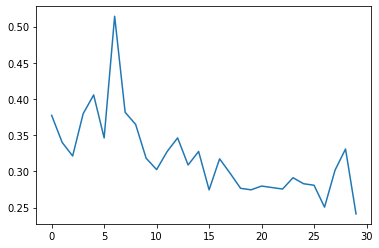

In [45]:
# Training
thetas_opt_mitigated, loss, accepted = optimize(phys_params, thetas = thetas_guess, max_iter=30, L=5,meas_fitter=meas_fitter) #, pick_optimizer="adam")
plt.plot(loss)

In [46]:
# Inference
cost_mitigated = np.zeros((len(gx_vals)))
shots = 1000
for i,p in enumerate(list(zip(gxs, gzs))):
    t0 = datetime.datetime.now()
    cost_mitigated[i] = cost_function_single(thetas_opt_mitigated, L, num_trash, i, shots=shots, meas_fitter=meas_fitter) # np.random.uniform(0, 2*np.pi, 2*L+2) random parameters to check if training "does" something - result was: with random paremters just get noise, so yes, it "does" something
    if not i%verbose:
        print(f"{i+1} / {len(opt_params)}, gx = {p[0]:.2f}, gz = {p[1]:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

1 / 7, gx = 0.01, gz = 0.00, time : 0:00:24.907091
2 / 7, gx = 0.04, gz = 0.00, time : 0:00:25.047941
3 / 7, gx = 0.18, gz = 0.00, time : 0:00:24.780153
4 / 7, gx = 0.78, gz = 0.00, time : 0:00:25.497984
5 / 7, gx = 3.36, gz = 0.00, time : 0:00:35.107116
6 / 7, gx = 14.38, gz = 0.00, time : 0:00:25.408261
7 / 7, gx = 61.58, gz = 0.00, time : 0:00:25.399309


In [49]:
"data/" + name + "_thetas-loss-cost_run2"

'data/ibmq_antiferro-1D-load_bogota-optimize_thetas-loss-cost_run2'

In [47]:
np.savez("data/" + name + "_thetas-loss-cost_run2",
         cost_mitigated=cost_mitigated, thetas_mitigated=thetas_opt_mitigated,
        )

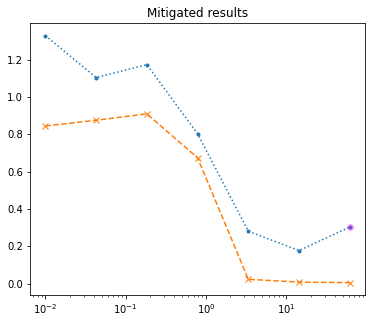

In [48]:
fig, ax = plt.subplots(ncols=1,figsize=(6,5))
ax.set_title("Mitigated results")
cost = np.load("data/" + name + "_thetas-loss-cost_run2.npz", allow_pickle=True)["cost_mitigated"]
ax.plot(gx_list, cost,".:", label="raw output")
ax.plot(gx_list, abs(Qmags),"x--", color="tab:orange", label="Qmag")
ax.set_xscale("log")
for p in phys_params:
    ax.plot(gx_list[p],cost[p],"o",alpha=0.3,color="magenta")